In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimPEG.Utils as Utils
from SimPEG.EM import TDEM
from SimPEG import Mesh, Maps
import discretize
import pickle 
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
from pymatsolver import Pardiso
import math
# Set a nice colormap! 
plt.set_cmap(plt.get_cmap('viridis'))

In [11]:
def diffusion_distance(sigma, time):
    return np.sqrt((2*time)/(sigma * mu_0))

sigma_air = 1e-8
sigma_near_surface = 3
sigma_basement = 1/100.0
thickness_near_surface = [0.,25.,50.,75.,100.,125.,150]

srcLocation = np.r_[0,0,0.5]
rxLocation = np.r_[0,0,0.5]

dbdt_sensor_delay = 2e-5
b_sensor_delay = 3e-5
ramp_off_time = 20e-6
source_current = 70
source_diameter = 25.
radius = math.sqrt(source_diameter**2/math.pi)
max_x = 300.
max_z = 300.
times = np.arange(0.00001,0.1,0.0001)+ramp_off_time

print(
    'min diffusion distance: {:.2f} m'.format(diffusion_distance(max(sigma_near_surface,sigma_basement), times.min()))
)
print(
    'max diffusion distance: {:.2f} m'.format(diffusion_distance(min(sigma_near_surface,sigma_basement), times.max()))
)

csx = 2
ncsx = max_x/csx
npadx = 17

csz = 2
ncsz = np.ceil(max_z/csz)
npadz = 17

pf = 1.7

hx = Utils.meshTensor([(csx,ncsx),(csx,npadx,pf)])
hz = Utils.meshTensor([(csz,npadz,-pf),(csz,ncsz),(csz,npadz,pf)])
mesh = Mesh.CylMesh([hx,1,hz],x0=np.r_[0,0,-hz.sum()/2. - max_z/2. + 5])
print(max(mesh.gridCC[:,0]),max(mesh.gridCC[:,2]),mesh.nC)



min diffusion distance: 3.99 m
max diffusion distance: 3988.03 m
32202.981529901546 31907.981529901546 30728


Text(0.5, 1.0, 'Simulation Mesh')

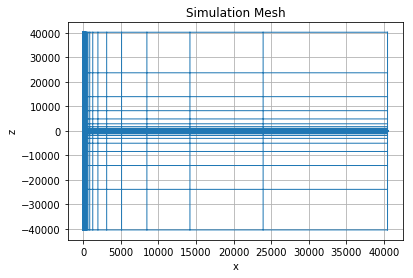

In [12]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

ax.set_title('Simulation Mesh')



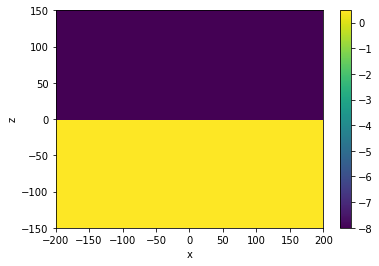

In [13]:
sigma = np.ones(mesh.nC) * sigma_air
sigma[mesh.gridCC[:,2] < 0. ] = sigma_near_surface
test_models = []
for thickness in thickness_near_surface:
    test_model = sigma.copy()
    test_model[mesh.gridCC[:,2]< -thickness] = sigma_basement
    test_models.append(test_model)

xlim = np.r_[-200., 200]
zlim = np.r_[-150, 150]
fig, ax = plt.subplots(1,1)
cb = plt.colorbar(mesh.plotImage(np.log10(sigma),mirror=True,ax=ax)[0])
ax.set_xlim(xlim)
ax.set_ylim(zlim)
plt.show()



In [14]:
dbdt_z = TDEM.Rx.Point_dbdt(locs=rxLocation, times=times, orientation='z')  # vertical db_dt
b_z = TDEM.Rx.Point_b(locs=rxLocation, times=times,orientation='z')
rxList = [dbdt_z,b_z]

timeSteps = [(1e-06, 10), (5e-06, 10), (1e-05, 10), (5e-5, 10), (1e-4, 10), (5e-4, 10), (1e-3, 10),(5e-3, 10),(1e-2,4)] 

wave = TDEM.Src.RampOffWaveform(offTime=ramp_off_time)

source = TDEM.Src.CircularLoop(rxList = rxList, loc=srcLocation, radius=radius, current=source_current, waveform=wave)

problems = []
surveys = []
for test_model in test_models:
    survey = TDEM.Survey([source])
    problem = TDEM.Problem3D_b(mesh, sigma=test_model, timeSteps=timeSteps, Solver=Pardiso)
    problem.pair(survey)
    problems.append(problem)
    surveys.append(survey)

print(
    'The maximum time is {:1.1e}. \n There are {} timesteps, '
    '{} of them distinct (which is the same as the number of matrices that need to be factored)'.format(
        problems[0].times[-1], problems[0].nT, (len(timeSteps))
    )
)



The maximum time is 1.1e-01. 
 There are 84 timesteps, 9 of them distinct (which is the same as the number of matrices that need to be factored)


In [15]:
fields = []
for problem in problems:
    field = problem.fields([])
    fields.append(field)


In [16]:
#Plot
from matplotlib.colors import LogNorm
import ipywidgets
field_to_plot = fields[0]
csx = 5
ncsx = 400/csx

csz = 5
ncsz = np.ceil(400/csz)

hx = Utils.meshTensor([(csx,ncsx)])
hz = Utils.meshTensor([(csz,ncsz)])
cartMesh = Mesh.TensorMesh([hx,hz,hz],'CCC')

projE = mesh.getInterpolationMatCartMesh(cartMesh,locType='E')
projF = mesh.getInterpolationMatCartMesh(cartMesh,locType='F')

xlim = [-100,100]
ylim = [-100,100]
stream_opts={"arrowsize":1.4, "color":"k", "density":0.85}

def plot(time_ind):
    fig, ax = plt.subplots(2,2,figsize=(12,10))

    #ax[0,0].set_aspect(1)
    f = cartMesh.plotSlice(
            projE*field_to_plot[source,'e',time_ind],
            ax=ax[0,0],
            vType='E',
            normal='Y',
            range_x=xlim,range_y=ylim
            )
 
    plt.colorbar(f[0], label='E field (V/m)',ax=ax[0,0])
    x = np.linspace(-400,400,100)
    y = np.zeros(len(x))
    ax[0,0].plot(x,y,'b-')
    y = np.ones(len(x))*-thickness_near_surface
    ax[0,0].plot(x,y,'b-')
    ax[0,0].set_title('$E_y$ Time {0:5.2f} ms'.format((problem.times[time_ind]-ramp_off_time)*1e3))
    ax[0,0].set_xlabel('radius (m)')
    ax[0,0].set_ylabel('z (m)')
    ax[0,0].set_xlim(xlim)
    ax[0,0].set_ylim(ylim)

    #ax[0,1].set_aspect(1)
    g = cartMesh.plotSlice(
            projE*field_to_plot[source,'j',time_ind],
            ax=ax[0,1],
            vType='E',
            normal='Y',
            range_x=xlim,range_y=ylim
            )

    plt.colorbar(g[0], label='(A/m)',ax = ax[0,1])
    x = np.linspace(-400,400,100)
    y = np.zeros(len(x))
    ax[0,1].plot(x,y,'b-')
    y = np.ones(len(x))*-thickness_near_surface
    ax[0,1].plot(x,y,'b-')
    ax[0,1].set_title('$J_y$ field Time {0:5.2f} ms'.format((problem.times[time_ind]-ramp_off_time)*1e3))
    ax[0,1].set_xlabel('radius (m)')
    ax[0,1].set_xlim(xlim)
    ax[0,1].set_ylim(ylim)

    #ax[1,0].set_aspect(1)
    k = cartMesh.plotSlice(
            cartMesh.aveF2CCV*projF*field_to_plot[source,'b',time_ind],
            ax=ax[1,0],
            vType='CCv',
            view='vec',
            normal='Y',
            pcolorOpts={
                'norm': LogNorm()
            },
            streamOpts=stream_opts,
            clim=[10e-14,10e-9]
            )

    plt.colorbar(k[0], label='(T)',ax=ax[1,0])
    x = np.linspace(-400,400,100)
    y = np.zeros(len(x))
    ax[1,0].plot(x,y,'b-')
    y = np.ones(len(x))*-thickness_near_surface
    ax[1,0].plot(x,y,'b-')
    ax[1,0].set_title('B field Time {0:5.2f} ms'.format((problem.times[time_ind]-ramp_off_time)*1e3))
    ax[1,0].set_xlabel('radius (m)')
    ax[1,0].set_ylabel('z (m)')
    ax[1,0].set_xlim(xlim)
    ax[1,0].set_ylim(ylim)

    #ax[1,1].set_aspect(1)
    l = cartMesh.plotSlice(
            cartMesh.aveF2CCV*projF*field_to_plot[source,'dbdt',time_ind],
            ax=ax[1,1],
            vType='CCv',
            view='vec',
            normal='Y',
            pcolorOpts={
                'norm': LogNorm()
            },
            streamOpts=stream_opts,
            clim=[10e-18,10e-12]
            )
    plt.colorbar(k[0], label=' (T/s)',ax=ax[1,1])
    x = np.linspace(-400,400,100)
    y = np.zeros(len(x))
    ax[1,1].plot(x,y,'b-')
    y = np.ones(len(x))*-thickness_near_surface
    ax[1,1].plot(x,y,'b-')
    ax[1,1].set_title('dB/dt field Time {0:5.2f} ms'.format((problem.times[time_ind]-ramp_off_time)*1e3))
    ax[1,1].set_xlabel('radius (m)')
    ax[1,1].set_xlim(xlim)
    ax[1,1].set_ylim(ylim)
   
    return f,g,k,l
# plt.tight_layout()
# plot(40)
# plt.show()
# ipywidgets.interact(
#     plot, 
#     time_ind=ipywidgets.IntSlider(min=1, max=len(problem.timeSteps)-1, value=1) 
# )



In [17]:
# from matplotlib.animation import FuncAnimation

# ani = FuncAnimation(fig,plot,len(problem.times),blit=True)

# ani.save('movie.mp4',dpi=200)



In [18]:
obs = []
for field,survey in zip(fields,surveys):
    ob = survey.dpred(sigma,f=field)
    obs.append(ob)


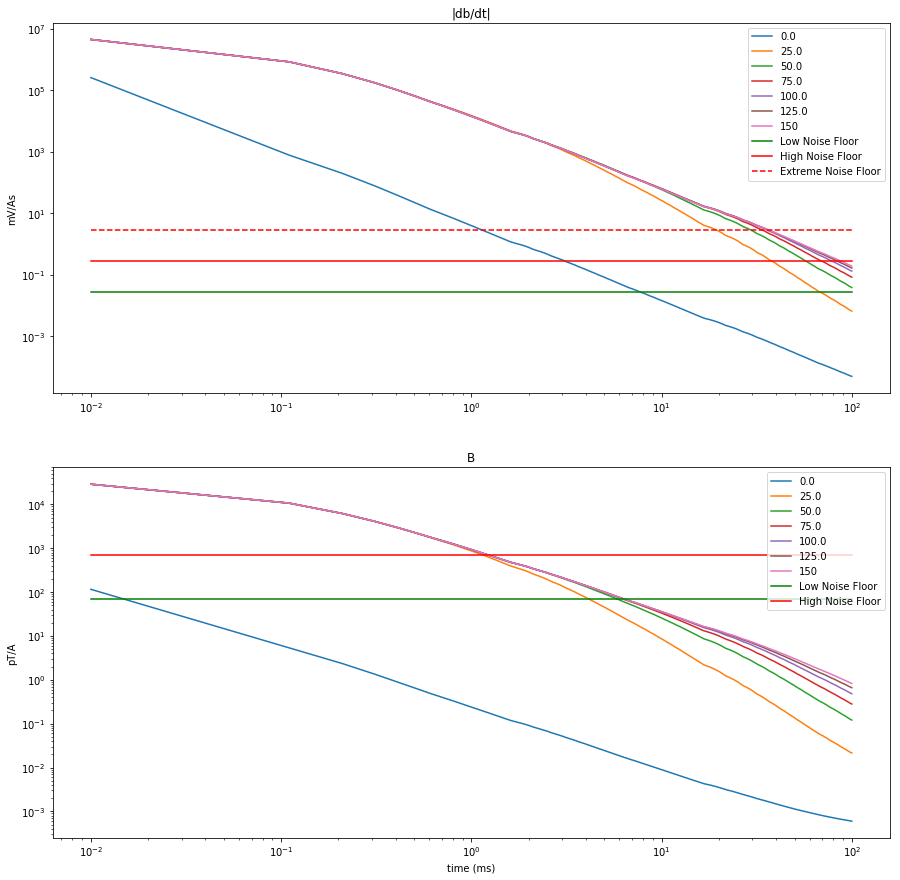

In [19]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
start_index = np.where(dbdt_z.times - ramp_off_time > 0)[0][0]

B_noise = 70 
B_noise_low = B_noise * np.ones(len((dbdt_z.times[start_index:])))
B_noise_high = 10*B_noise * np.ones(len((dbdt_z.times[start_index:])))

dbdt_abs_noise = 2 
dbdt_noise_low=dbdt_abs_noise*np.ones(len((dbdt_z.times[start_index:])))/source_current
dbdt_noise_high=10*dbdt_abs_noise*np.ones(len((dbdt_z.times[start_index:])))/source_current
dbdt_noise_vhigh=100*dbdt_abs_noise*np.ones(len((dbdt_z.times[start_index:])))/source_current

for ob, thickness in zip(obs,thickness_near_surface):
    to_plot = np.reshape(ob,(len(dbdt_z.times),2),order='F')

    ax[0].loglog((dbdt_z.times[start_index:]-ramp_off_time)*1e3,1e6*10000*abs(to_plot[start_index:,0])/source_current,label=str(thickness))
    ax[1].loglog((dbdt_z.times[start_index:]-ramp_off_time)*1e3,1e12*abs(to_plot[start_index:,1])/source_current,label=str(thickness))

ax[0].set_title('|db/dt|')
ax[0].set_ylabel('mV/As')
ax[0].loglog((dbdt_z.times[start_index:]-ramp_off_time)*1e3,dbdt_noise_low,'g-',label=('Low Noise Floor'))
ax[0].loglog((dbdt_z.times[start_index:]-ramp_off_time)*1e3,dbdt_noise_high,'r-',label=('High Noise Floor'))
ax[0].loglog((dbdt_z.times[start_index:]-ramp_off_time)*1e3,dbdt_noise_vhigh,'r--',label=('Extreme Noise Floor'))
ax[0].legend(loc='upper right')

ax[1].loglog((dbdt_z.times[start_index:]-ramp_off_time)*1e3,B_noise_low,'g-',label=('Low Noise Floor'))
ax[1].loglog((dbdt_z.times[start_index:]-ramp_off_time)*1e3,B_noise_high,'r-',label=('High Noise Floor'))

ax[1].set_xlabel('time (ms)')
ax[1].set_title('B')
ax[1].set_ylabel('pT/A')
ax[1].legend(loc='upper right')
plt.show()